<a href="https://colab.research.google.com/github/jbarsce/AprendizajePorRefuerzos/blob/master/lab_1_intro_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resolución Práctico N°1

# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2023


## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por $\pi(a \mid s) = 1 - \epsilon$ si $a$ es la mejor acción, caso contrario pasa a estar dada por $\pi(a \mid s) = \epsilon$.

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/sarsa.png?raw=1)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/q_learning.png?raw=1)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Librería OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee cinco métodos principales:

* ```reset(self, seed)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado. Opcionalmente, establece la semilla aleatoria del generador de números aleatorios del presente entorno.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, terminated, truncated, info```.

* ```render(self)``` : Muestra en pantalla una parte del ambiente.

* ```close(self)``` : Finaliza con la instancia del agente.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```apt-get install ffmpeg```

desde Mac, reemplazar *apt-get* por *brew*

desde Windows, descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

Código básico de importación y funciones de graficación (no modificar)

In [669]:
# @title Código básico importacion y utilerías (no modificar)

import itertools
from typing import Any, Callable, Tuple
import numpy as np
import matplotlib.pyplot as plt


def plot_reward_per_episode(reward_ep,algoritmo) -> None:
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title(f"Recompensa acumulada por episodio - {algoritmo}")
    plt.show()


def plot_steps_per_episode(timesteps_ep,algoritmo) -> None:
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title(f"Pasos (timesteps) por episodio - {algoritmo}")
    plt.show()


def plot_steps_per_episode_smooth(timesteps_ep,algoritmo) -> None:
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    plt.plot(steps_per_episode)
    plt.title(f"Pasos (timesteps) acumulados por episodio - {algoritmo}")
    plt.show()


def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

## Ejemplo 1: Agente CartPole.

En este ejemplo, realicé algunas modificaciones para poder visualizar el ejercicio e imprimí los resultados de cada observación y episodio

In [670]:
from IPython.display import clear_output
import gymnasium as gym

env = gym.make('CartPole-v1',render_mode="human") #Con render "human", consigo visualizar el ejercicio.
env.reset()

total_reward = 0 

for _ in range(500):
    obs, reward, terminated, truncated, info = env.step(
      env.action_space.sample())
    
    total_reward += reward
    
    #Imprimimos el resultado de cada observación y su recompensa.

    print(f"Observación (obs): {obs}")
    print(f"Recompensa (reward): {reward}")
    print(f"Terminado (terminated): {terminated}")
    print(f"Truncado (truncated): {truncated}")
    print(f"Información (info): {info}")
    print("-" * 50)

    done = terminated or truncated
    if done:
      #En caso de finalizar o de truncarse, imprimos el resultado de la reconpensa acumulada en el episodio.
      print(f"Recompensa total acumulada en el episodio: {total_reward}")
      print("=" * 50)
        
      #Reiniciamos el entorno
      env.reset()
      total_reward = 0
      
env.close()

Observación (obs): [ 0.0354849   0.19036447 -0.01487151 -0.33974037]
Recompensa (reward): 1.0
Terminado (terminated): False
Truncado (truncated): False
Información (info): {}
--------------------------------------------------
Observación (obs): [ 0.03929219  0.38569483 -0.02166632 -0.6370756 ]
Recompensa (reward): 1.0
Terminado (terminated): False
Truncado (truncated): False
Información (info): {}
--------------------------------------------------
Observación (obs): [ 0.04700608  0.58111215 -0.03440783 -0.9365021 ]
Recompensa (reward): 1.0
Terminado (terminated): False
Truncado (truncated): False
Información (info): {}
--------------------------------------------------
Observación (obs): [ 0.05862832  0.77668077 -0.05313788 -1.2397953 ]
Recompensa (reward): 1.0
Terminado (terminated): False
Truncado (truncated): False
Información (info): {}
--------------------------------------------------
Observación (obs): [ 0.07416194  0.5822799  -0.07793378 -0.9642209 ]
Recompensa (reward): 1.0
Te

### El resultado de ejecutar el video es el siguiente:

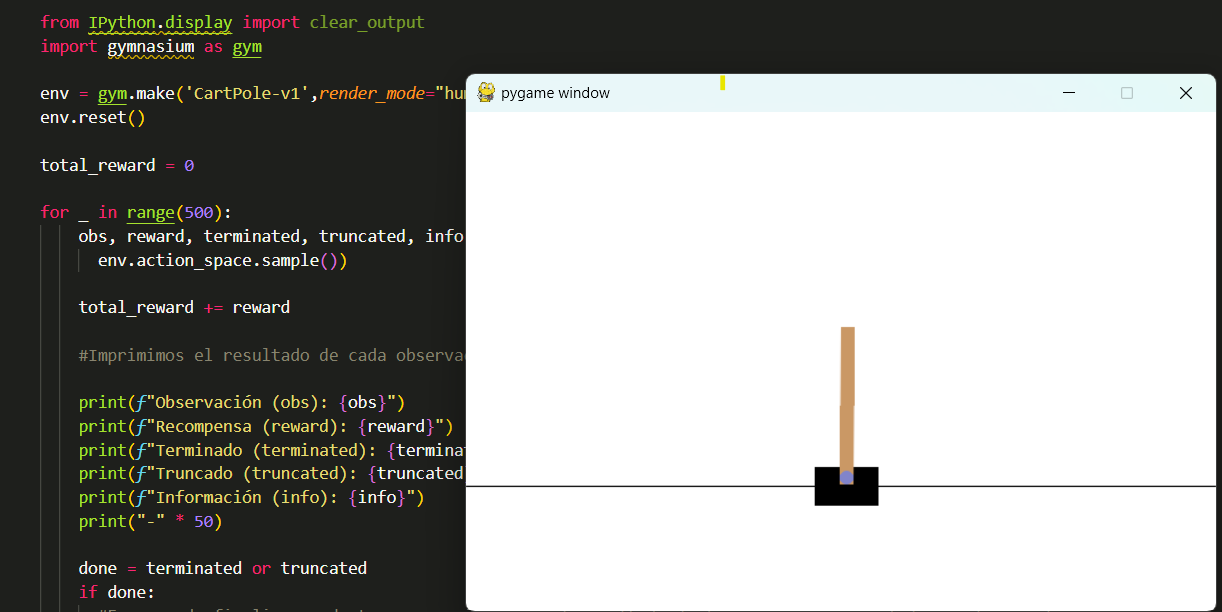

## Ejemplo 2: Agente Mountain Car.

Modificamos tambien el código para observar gráficamente e imprimir los resultados. Aún con 1000 pasos al no especificar un algoritmo de aprendizaje no logra llegar a la cima.

In [671]:
env = gym.make('MountainCar-v0',render_mode="human", max_episode_steps=1000)
obs = env.reset()
for t in range(1000):
    env.render()
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    #Imprimimos los resultados del entorno Mountaincar para mayor análisis.
    print(f"Observación (obs): {obs}")
    print(f"Recompensa (reward): {reward}")
    print(f"Terminado (terminated): {terminated}")
    print(f"Truncado (truncated): {truncated}")
    print(f"Información (info): {info}")
    print("-" * 50)

    done = terminated or truncated
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()

Observación (obs): [-4.2577744e-01  2.7882741e-04]
Recompensa (reward): -1.0
Terminado (terminated): False
Truncado (truncated): False
Información (info): {}
--------------------------------------------------
Observación (obs): [-0.4252218   0.00055565]
Recompensa (reward): -1.0
Terminado (terminated): False
Truncado (truncated): False
Información (info): {}
--------------------------------------------------
Observación (obs): [-0.4263933  -0.00117151]
Recompensa (reward): -1.0
Terminado (terminated): False
Truncado (truncated): False
Información (info): {}
--------------------------------------------------
Observación (obs): [-0.42928356 -0.00289026]
Recompensa (reward): -1.0
Terminado (terminated): False
Truncado (truncated): False
Información (info): {}
--------------------------------------------------
Observación (obs): [-0.4328718  -0.00358823]
Recompensa (reward): -1.0
Terminado (terminated): False
Truncado (truncated): False
Información (info): {}
------------------------------

### El resultado de ejecutar el video es el siguiente:

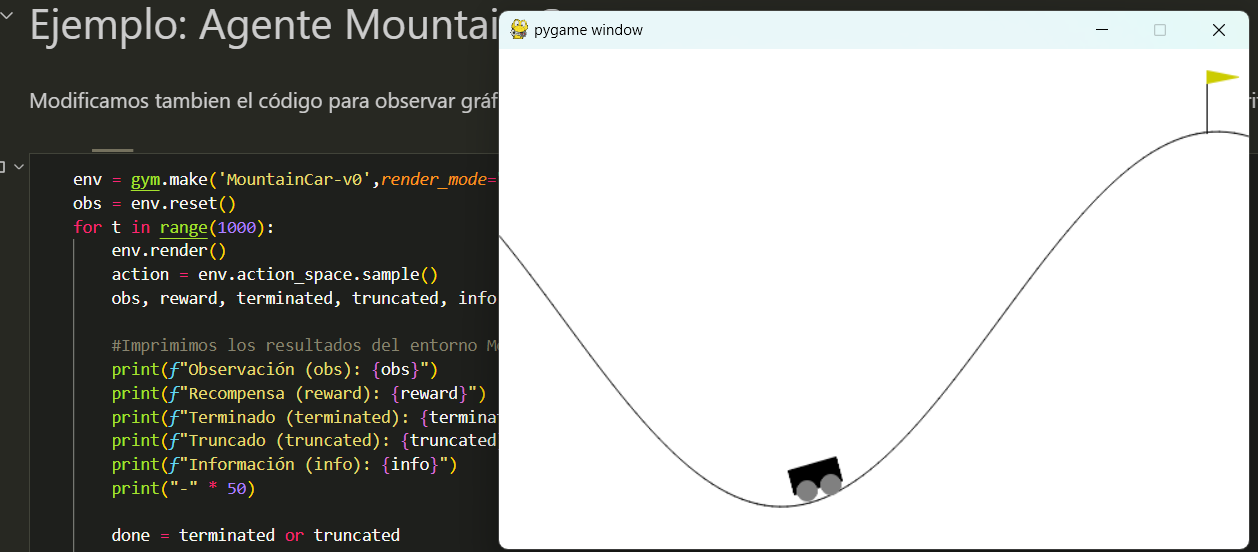



## Ejemplo 3: The Cliff.


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

### a) Política E-Greedy

In [672]:
def choose_action_e_greedy(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política de exploración épsilon-greedy
    """
    # ej: para 4 acciones inicializa en [0,0,0,0]
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)
    # sorteamos un número: es menor a épsilon?
    if random_state.uniform() < hyperparameters['epsilon']:
        # sí: se selecciona una acción aleatoria
        return random_state.choice(actions)

    count = q_values.count(max_q)

    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]


### c) Método Principal de Iteraciones

In [673]:
def run(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
    random_state: np.random.RandomState,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual.
        # Filtra el primer elemento de state, que es el estado en sí mismo
        action = choose_action_e_greedy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_action = choose_action_e_greedy(
                next_state, actions, q, hyperparameters, random_state)

            episode_reward += reward

            try:
                learning_function(
                    state,
                    action,
                    reward,
                    next_state,
                    next_action,
                    hyperparameters,
                    q
                )
            except:
                learning_function(
                state,
                action,
                reward,
                next_state,
                hyperparameters,
                q
            )

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 500:
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode 

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

## Resolución

### 1) Sarsa en The Cliff

#### 1.1) Algortimo

In [674]:
def learn_SARSA(
        state: int,               # Estado Actual.
        action: int,              # Acción llevada a cabo en el estado actual.
        reward: float,            # Recompensa por la acción llevada a cabo.
        next_state: int,          # Estado siguiente después de realizar la acción.
        next_action: int,         # Próxima acción en el estado siguiente.
        hyperparameters: dict,    # Hiperparámetros.
        q: dict                   # Valores Q de cada par estado-acción.
) -> None:

    # Hiperparámetros
    alpha = hyperparameters['alpha']  # Tasa de aprendizaje
    gamma = hyperparameters['gamma']  # Factor de descuento

    # Inicializamos los valores Q para (estado, acción) si no existen
    if (state, action) not in q:
        q[(state, action)] = 0.0  # Valor inicial predeterminado
    
    if (next_state, next_action) not in q:
        q[(next_state, next_action)] = 0.0  # Valor inicial predeterminado

    # Fórmula de actualización de SARSA
    q[(state, action)] = q[(state, action)] + alpha * (reward + gamma * q[(next_state, next_action)] - q[(state, action)])


#### 1.2) Ajuste de hiperparametros 

In [675]:
q = {}

#Algoritmo a utilizar
learning_function = learn_SARSA
#Episodios a correr
episodes_to_run = 500

hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
}

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

#Semilla Aleatoria
random_state = np.random.RandomState(42)

#### 1.3) Ejecución

In [676]:
avg_steps_per_episode_sarsa, timesteps_ep_sarsa, reward_ep_sarsa = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

#### 1.4) Convergencia

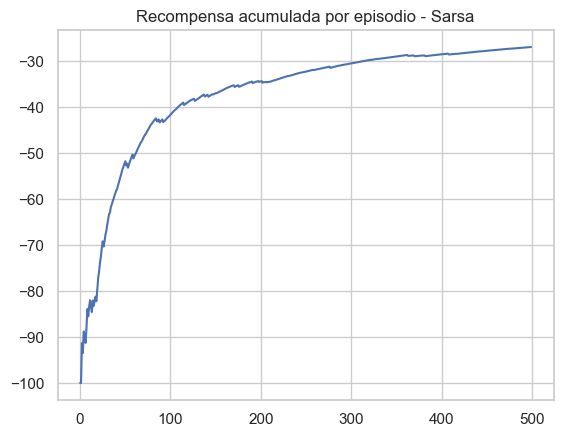

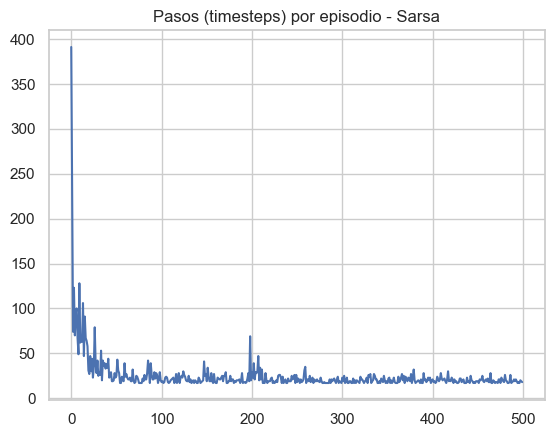

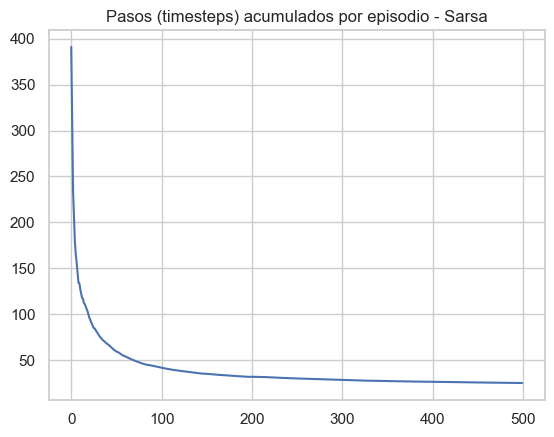

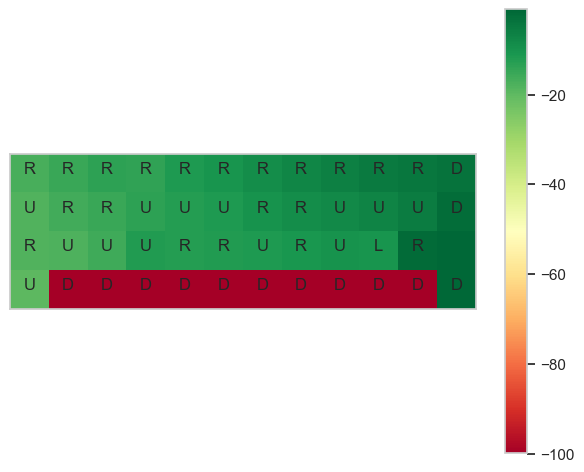


 Matriz de mejor acción-valor (en números): 

 [[ -17.23954428  -15.14316652  -13.47940719  -13.86734791  -11.50591433
   -10.42824021   -8.92910114   -7.36906975   -6.09772006   -5.02260286
    -4.246717     -3.48743802]
 [ -18.17688817  -16.29163152  -15.09887514  -13.57191616  -12.57200446
   -11.46204211  -10.28051994   -8.75636874   -8.02140089   -7.17268501
    -5.41325753   -2.24362335]
 [ -18.16818774  -17.96726471  -16.02741607  -12.12753358  -12.36502775
   -11.94064567  -11.56233996  -10.96253903   -9.96154144  -10.28531687
    -2.00258599   -1.        ]
 [ -19.72790699 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [677]:
plot_reward_per_episode(reward_ep_sarsa,'Sarsa')
plot_steps_per_episode(timesteps_ep_sarsa,'Sarsa')
plot_steps_per_episode_smooth(timesteps_ep_sarsa,'Sarsa')
draw_value_matrix(q)

### 2) Q-Learning en The Cliff

#### 2.1) Algoritmo

In [678]:
def learn_Q_learning(
        state: int,               # El estado actual
        action: int,              # La acción tomada en el estado actual
        reward: float,            # La recompensa obtenida al tomar la acción
        next_state: int,          # El siguiente estado después de realizar la acción
        hyperparameters: dict,    # Hiperparámetros como alpha, gamma, epsilon
        q: dict                   # La tabla Q
) -> None:
    """
    Realiza una actualización según el algoritmo Q-learning, para una transición
    de estado dada.
    """
    # Parámetros
    alpha = hyperparameters['alpha']  # Tasa de aprendizaje
    gamma = hyperparameters['gamma']  # Factor de descuento

    # Calculamos el valor máximo Q en el próximo estado
    best_next_action = max([q.get((next_state, a), 0.0) for a in actions])

    # Actualización de Q para Q-learning
    q[state, action] = q.get((state, action), 0.0) + alpha * (
        reward + gamma * best_next_action - q.get((state, action), 0.0)
    )


#### 2.2) Ajuste de Hiperparámetros

In [679]:
# Para cada estado y acción posibles, inicializar el valor Q a 0
q = {}


#Algoritmo a utilizar
learning_function = learn_Q_learning
#Episodios a correr
episodes_to_run = 500

#Elección de Hiperparámetros
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "action_space": env.action_space.n 
}

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

#Semilla Aleatoria
random_state = np.random.RandomState(42)

#### 2.3) Ejecución

In [680]:
avg_steps_per_episode_qlearning, timesteps_ep_qlearning, reward_ep_qlearning = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

#### 2.4) Convergencia

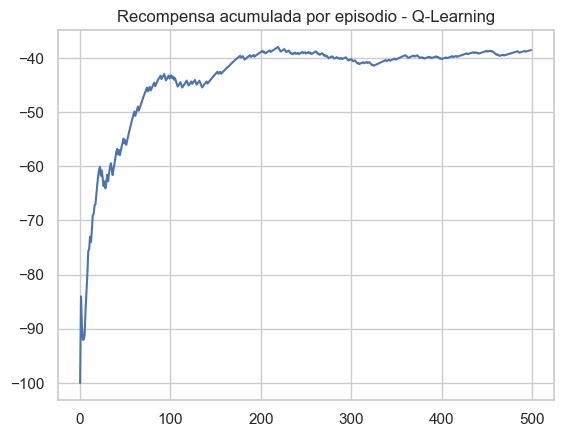

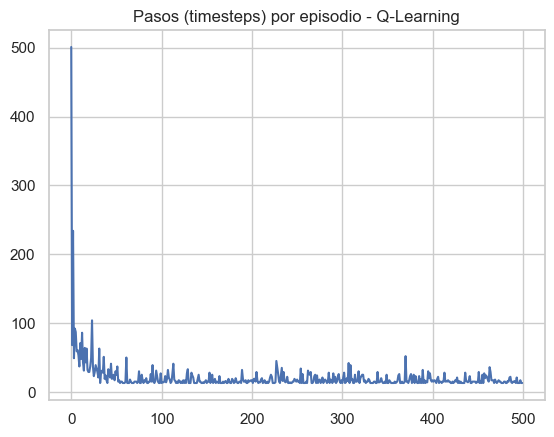

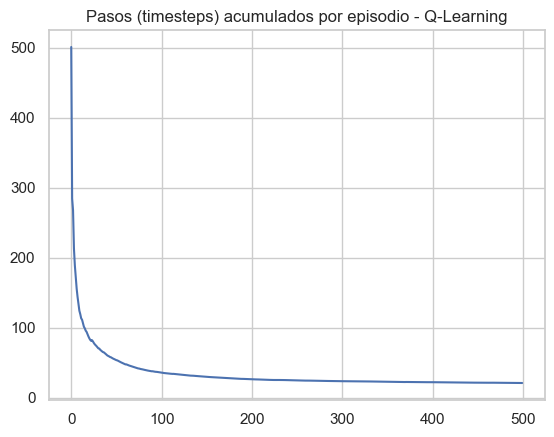

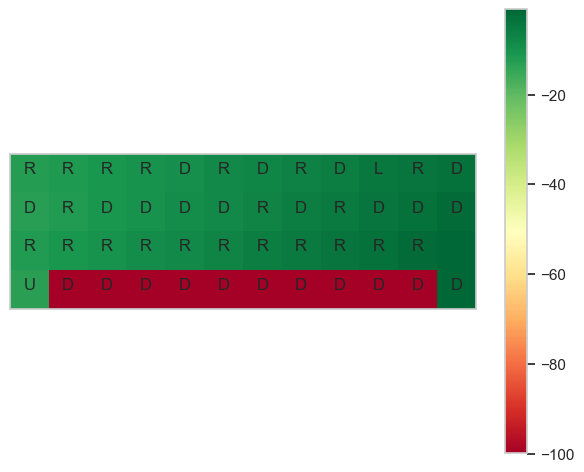


 Matriz de mejor acción-valor (en números): 

 [[ -12.31371038  -11.55931581  -10.74214765   -9.93786876   -9.13260325
    -8.33957853   -7.42586678   -6.62048911   -5.73356272   -4.85675812
    -3.92603401   -2.99743099]
 [ -12.79954002  -11.92280135  -10.96340095   -9.99211319   -8.99910773
    -7.99973034   -6.99992566   -5.99998699   -4.99999843   -3.99999936
    -2.99999996   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [681]:
plot_reward_per_episode(reward_ep_qlearning,'Q-Learning')
plot_steps_per_episode(timesteps_ep_qlearning,'Q-Learning')
plot_steps_per_episode_smooth(timesteps_ep_qlearning,'Q-Learning')
draw_value_matrix(q)

### 3) Análisis de Convergencia

#### 3.1) Funciones Gráficas

In [682]:
def plot_reward_per_episode_agrupado(reward_ep1, reward_ep2, algoritmo1, algoritmo2) -> None:

    # Acumulando las recompensas de cada conjunto
    episode_rewards1 = np.array(reward_ep1)
    episode_rewards2 = np.array(reward_ep2)

    # Suavizando la curva de convergencia
    episode_number = np.linspace(1, len(episode_rewards1) + 1, len(episode_rewards1) + 1)
    
    acumulated_rewards1 = np.cumsum(episode_rewards1)
    acumulated_rewards2 = np.cumsum(episode_rewards2)

    reward_per_episode1 = [
        acumulated_rewards1[i] / episode_number[i] for i in range(len(acumulated_rewards1))
    ]
    reward_per_episode2 = [
        acumulated_rewards2[i] / episode_number[i] for i in range(len(acumulated_rewards2))
    ]

    # Graficando las dos series con colores distintos
    plt.plot(reward_per_episode1, label=algoritmo1, color='b')  # Serie 1, color azul
    plt.plot(reward_per_episode2, label=algoritmo2, color='r')  # Serie 2, color rojo
    # Títulos y leyenda
    plt.title("Recompensa acumulada por episodio")
    plt.xlabel("Número de episodios")
    plt.ylabel("Recompensa acumulada")
    plt.legend()
    plt.show()

def plot_steps_per_episode_agrupado(timesteps_ep1, timesteps_ep2, algoritmo1, algoritmo2) -> None:
    """
    Grafica los pasos por episodio de dos algoritmos, cada uno con su respectivo color.
    
    timesteps_ep1: lista de pasos por episodio del primer algoritmo
    timesteps_ep2: lista de pasos por episodio del segundo algoritmo
    algoritmo1: nombre del primer algoritmo (para el título de la leyenda)
    algoritmo2: nombre del segundo algoritmo (para el título de la leyenda)
    """
    # Convertir los timesteps a arrays de numpy
    episode_steps1 = np.array(timesteps_ep1)
    episode_steps2 = np.array(timesteps_ep2)

    # Graficar los pasos por episodio de ambos algoritmos con colores diferentes
    plt.plot(np.array(range(0, len(episode_steps1))), episode_steps1, label=algoritmo1, color='b')  # Serie 1, color azul
    plt.plot(np.array(range(0, len(episode_steps2))), episode_steps2, label=algoritmo2, color='r')  # Serie 2, color rojo
    
    # Títulos y leyenda
    plt.title("Pasos (timesteps) por episodio")
    plt.xlabel("Número de episodios")
    plt.ylabel("Pasos por episodio")
    plt.legend()
    plt.show()

def plot_steps_per_episode_smooth_agrupado(timesteps_ep1, timesteps_ep2, algoritmo1, algoritmo2) -> None:
    """
    Grafica los pasos acumulados por episodio de dos algoritmos con suavizado, cada uno con su respectivo color.
    
    timesteps_ep1: lista de pasos por episodio del primer algoritmo
    timesteps_ep2: lista de pasos por episodio del segundo algoritmo
    algoritmo1: nombre del primer algoritmo (para el título de la leyenda)
    algoritmo2: nombre del segundo algoritmo (para el título de la leyenda)
    """
    # Convertir los timesteps a arrays de numpy
    episode_steps1 = np.array(timesteps_ep1)
    episode_steps2 = np.array(timesteps_ep2)

    # Suavizado de la curva de aprendizaje para el primer algoritmo
    episode_number1 = np.linspace(1, len(episode_steps1) + 1, len(episode_steps1) + 1)
    acumulated_steps1 = np.cumsum(episode_steps1)
    steps_per_episode1 = [acumulated_steps1[i] / episode_number1[i] for i in range(len(acumulated_steps1))]

    # Suavizado de la curva de aprendizaje para el segundo algoritmo
    episode_number2 = np.linspace(1, len(episode_steps2) + 1, len(episode_steps2) + 1)
    acumulated_steps2 = np.cumsum(episode_steps2)
    steps_per_episode2 = [acumulated_steps2[i] / episode_number2[i] for i in range(len(acumulated_steps2))]

    # Graficar las dos series suavizadas con colores diferentes
    plt.plot(steps_per_episode1, label=algoritmo1, color='b')  # Serie 1, color azul
    plt.plot(steps_per_episode2, label=algoritmo2, color='r')  # Serie 2, color rojo
    
    # Títulos y leyenda
    plt.title("Pasos (timesteps) acumulados por episodio")
    plt.xlabel("Número de episodios")
    plt.ylabel("Pasos acumulados por episodio")
    plt.legend()
    plt.show()





#### 3.2) Análisis

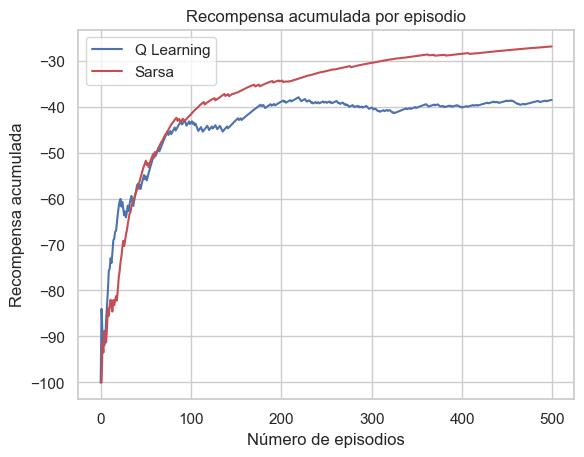

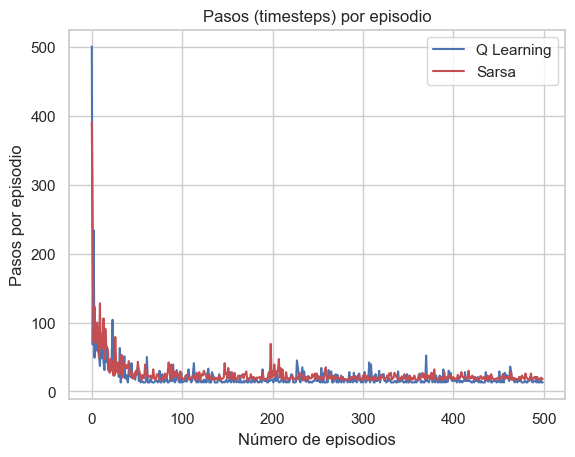

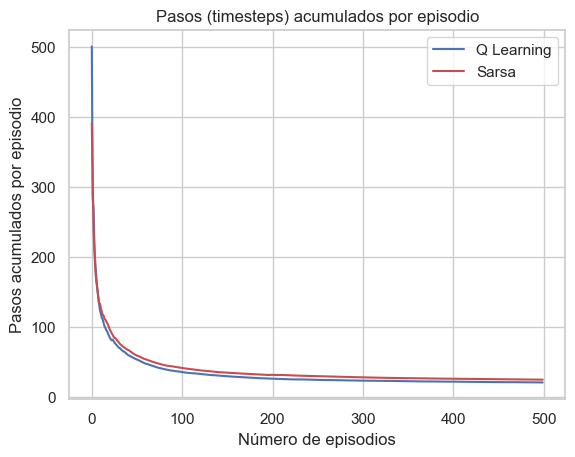

In [683]:
plot_reward_per_episode_agrupado(reward_ep_qlearning,reward_ep_sarsa,'Q Learning','Sarsa')
plot_steps_per_episode_agrupado(timesteps_ep_qlearning,timesteps_ep_sarsa,'Q Learning','Sarsa')
plot_steps_per_episode_smooth_agrupado(timesteps_ep_qlearning,timesteps_ep_sarsa,'Q Learning','Sarsa')

A simple vista y analizando las gráficas, podemos extraer las siguientes conclusiones, considerando que utilizamos los mismos hiperparámetros tanto para Sarsa como para Q-Learning,

* Al inicio del entrenamiento, Q-Learning muestra una mayor exploración, esto implica un crecimiento más rápido de las recompensas acumuladas en los primeros episodios. Esto se da porque  Q-Learning sigue una política sin restricciones, favoreciendo la exploración sin importar las recompensas inmediatas, lo que le permite descubrir rápidamente una mayor variedad de acciones y estados. SARSA, en cambio, tiene un enfoque más conservador, basándose en las acciones realmente tomadas bajo la política 
E-Greedy.
* En el largo plazo (500 episodios), particularmente después del episodio 100, SARSA demuestra una mayor eficiencia en la acumulación de recompensas. Esto es debido a su estrategia más conservadora, que favorece la explotación de las mejores políticas aprendidas a lo largo del tiempo, en lugar de seguir explorando caminos que pueden ser subóptimos. En cambio, Q-Learning, muestra una tendencia a estabilizarse a un valor más bajo de recompensas acumuladas (alrededor de -40), lo que nos indica que puede estar tomando decisiones subóptimas durante el proceso de exploración.
* Q-Learning muestra una mayor cantidad de pasos por episodio al inicio y mantiene una variabilidad reducida a medida que se acerca a los 500 episodios. Esto puede indicar que el algoritmo, al explorar más al principio y menos después, está tomando decisiones más informadas a medida que progresa. SARSA requiere más pasos al final debido a su naturaleza conservadora. Sin embargo, a medida que progresa, el número de pasos también disminuye, reflejando una mejora en la política aprendida.

### 4) Prueba de Hiperparámetros

#### 4.1) Funciones

In [684]:
#Función para la prueba de diferentess hiperparametros
def run_multiple_hyperparameters(learning_function, episodes_to_run, env, actions, q, random_state, hyperparameter_combinations):
    results = []

    for hyperparameters in hyperparameter_combinations:
        print(f"Ejecutando con hiperparámetros: {hyperparameters}")
        q = {}
        # Ejecutar el algoritmo con los hiperparámetros actuales
        avg_steps_per_episode, timesteps_ep, reward_ep = run(
            learning_function,
            hyperparameters,
            episodes_to_run,
            env,
            actions,
            q,
            random_state
        )
        
        # Almacenar los resultados
        results.append({
            'alpha': hyperparameters['alpha'],
            'gamma': hyperparameters['gamma'],
            'epsilon': hyperparameters['epsilon'],
            'reward_ep': reward_ep,
            'timesteps_ep': timesteps_ep,
            'avg_steps_per_episode': avg_steps_per_episode
        })
    
    return results

In [685]:
def plot_reward_per_episode_multiples_hiperparametros(results, algoritmo, título, objetivo_key="reward_ep") -> None:
    plt.figure(figsize=(6, 4))
    
    for result in results:
        alpha = result['alpha']
        gamma = result['gamma']
        epsilon = result['epsilon']
        _objetivo = result[objetivo_key]  # Usar la clave especificada
        
        # Convertir a array para cálculos
        episode_rewards = np.array(_objetivo)

        # Suavizar la curva de convergencia
        episode_number = np.linspace(
            1, len(episode_rewards), len(episode_rewards)
        )
        acumulated_rewards = np.cumsum(episode_rewards)

        reward_per_episode = [
            acumulated_rewards[i] / episode_number[i]
            for i in range(len(acumulated_rewards))
        ]

        # Graficar con una etiqueta específica
        label = f"α={alpha}, γ={gamma}, ε={epsilon}"
        plt.plot(reward_per_episode, label=label)

    # Configurar el gráfico
    plt.title(f"{título} - {algoritmo}")
    plt.xlabel("Episodio")
    plt.ylabel(f"{objetivo_key}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### 4.2) Sarsa

##### 4.2.1) Alpha

El hiperparámetro alpha, modifica la tasa de aprendizaje del agente, por ende una tasa mas alta hará que el agente aprenda más rápido, teniendo más en cuenta a la información reciente, adaptandose a los cambios que esta implica. Sin embargo, en el largo plazo puede generar mayor inestabilidad. Vemos en los gráficos que una tasa muy alta de 0,7 incrementa mucho la velocidad de aprendizaje, evidenciado por la pendiente de la recompensa en función de los episodios, pero finalmente dicha serie es la que converge al valor más bajo de recompensas acumuladas.

Ejecutando con hiperparámetros: {'alpha': 0.2, 'gamma': 1, 'epsilon': 0.1, 'action_space': 4}
Ejecutando con hiperparámetros: {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1, 'action_space': 4}
Ejecutando con hiperparámetros: {'alpha': 0.7, 'gamma': 1, 'epsilon': 0.1, 'action_space': 4}


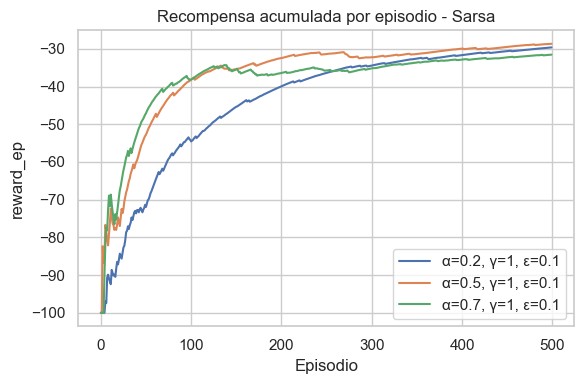

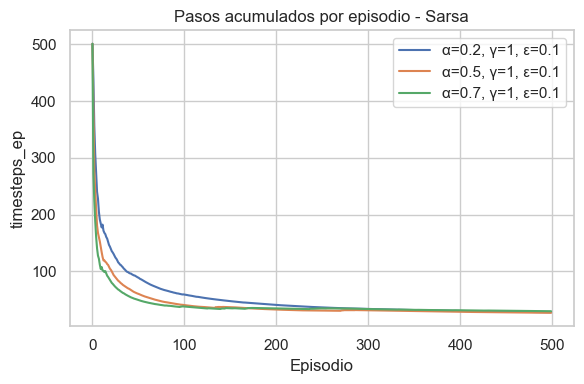

In [686]:
hyperparameter_combinations = [
    {'alpha': 0.2, 'gamma': 1, 'epsilon': 0.1, 'action_space': env.action_space.n},
    {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1, 'action_space': env.action_space.n},
    {'alpha': 0.7, 'gamma': 1, 'epsilon': 0.1, 'action_space': env.action_space.n},
]

# Inicializar el entorno y las variables
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
q = {}
random_state = np.random.RandomState(42)
learning_function = learn_SARSA  # Asumiendo que ya tienes esta función definida
episodes_to_run = 500  # Número de episodios a ejecutar

# Ejecutar los experimentos
results = run_multiple_hyperparameters(learning_function, episodes_to_run, env, actions, q, random_state, hyperparameter_combinations)

plot_reward_per_episode_multiples_hiperparametros(results, "Sarsa",'Recompensa acumulada por episodio',objetivo_key="reward_ep")
plot_reward_per_episode_multiples_hiperparametros(results, "Sarsa",'Pasos acumulados por episodio',objetivo_key="timesteps_ep")


##### 4.2.2) Gamma

El hiperparámetro Gamma, es la tasa de descuento, por lo tanto un valor bajo hace que el agente priorice acciones y recompensas inmediatas en post de recompensas futuras que otorgan menos valor en su utilidad. Por ende es de esperar, como se observa en los gráficos, que las recompensas en los episodios iniciales sean mas altas que en el largo plazo, en el cuál se genera cierta inestabilidad

Ejecutando con hiperparámetros: {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1, 'action_space': 4}
Ejecutando con hiperparámetros: {'alpha': 0.5, 'gamma': 0.95, 'epsilon': 0.1, 'action_space': 4}
Ejecutando con hiperparámetros: {'alpha': 0.5, 'gamma': 0.9, 'epsilon': 0.1, 'action_space': 4}


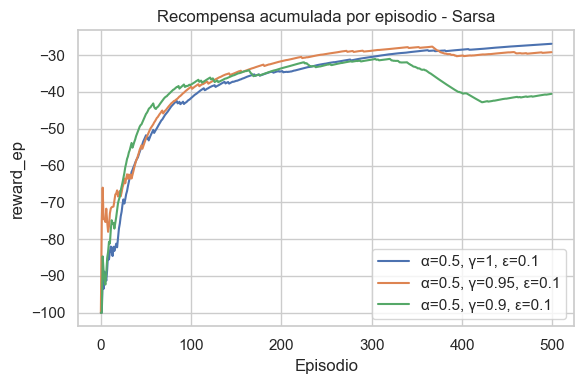

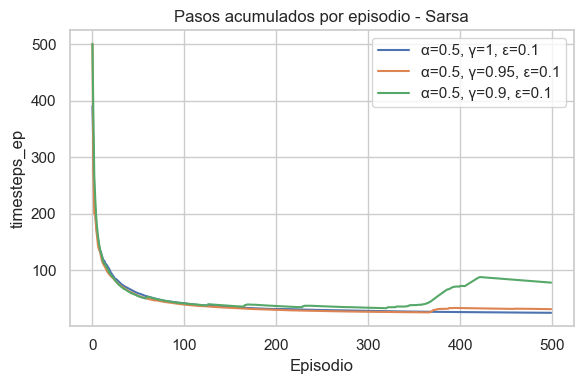

In [687]:
hyperparameter_combinations = [
    {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1, 'action_space': env.action_space.n},
    {'alpha': 0.5, 'gamma': 0.95, 'epsilon': 0.1, 'action_space': env.action_space.n},
    {'alpha': 0.5, 'gamma': 0.9, 'epsilon': 0.1, 'action_space': env.action_space.n},
]

# Inicializar el entorno y las variables
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
q = {}
random_state = np.random.RandomState(42)
learning_function = learn_SARSA  # Asumiendo que ya tienes esta función definida
episodes_to_run = 500  # Número de episodios a ejecutar

# Ejecutar los experimentos
results = run_multiple_hyperparameters(learning_function, episodes_to_run, env, actions, q, random_state, hyperparameter_combinations)

plot_reward_per_episode_multiples_hiperparametros(results, "Sarsa",'Recompensa acumulada por episodio',objetivo_key="reward_ep")
plot_reward_per_episode_multiples_hiperparametros(results, "Sarsa",'Pasos acumulados por episodio',objetivo_key="timesteps_ep")

##### 4.2.3) Epsilon

El hiperpámetro Epsilon está controlando la tasa de explotación/exploración. Esto implica, que a mayor Epsilon, mayor es la propensión del agente a explorar nuevas estrategias sin hacer uso del conocimiento adquirido hasta el momento. Como se observa en los gráficos, ello redunda en un menor nivel de recompensas acumuladas para el agente en el caso del algoritmo Sarsa y con una política E-Greedy.

Ejecutando con hiperparámetros: {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1, 'action_space': 4}
Ejecutando con hiperparámetros: {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.2, 'action_space': 4}
Ejecutando con hiperparámetros: {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.3, 'action_space': 4}


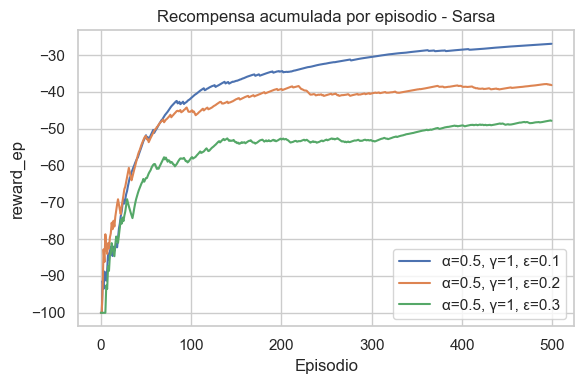

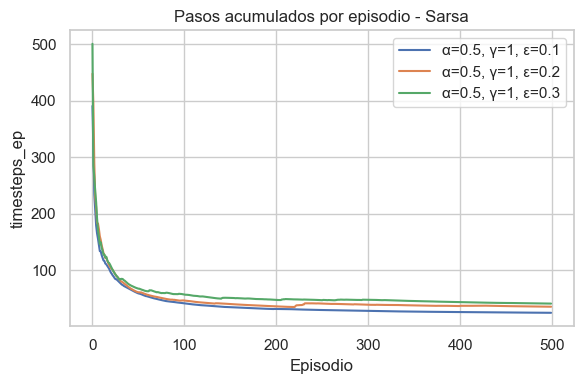

In [688]:
hyperparameter_combinations = [
    {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1, 'action_space': env.action_space.n},
    {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.2, 'action_space': env.action_space.n},
    {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.3, 'action_space': env.action_space.n},
]

# Inicializar el entorno y las variables
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
q = {}
random_state = np.random.RandomState(42)
learning_function = learn_SARSA  # Asumiendo que ya tienes esta función definida
episodes_to_run = 500  # Número de episodios a ejecutar

# Ejecutar los experimentos
results = run_multiple_hyperparameters(learning_function, episodes_to_run, env, actions, q, random_state, hyperparameter_combinations)

plot_reward_per_episode_multiples_hiperparametros(results, "Sarsa",'Recompensa acumulada por episodio',objetivo_key="reward_ep")
plot_reward_per_episode_multiples_hiperparametros(results, "Sarsa",'Pasos acumulados por episodio',objetivo_key="timesteps_ep")

#### 4.3) Q-Learning

##### 4.3.1) Alpha

En este caso la tasa de aprendizaje mejora levemente los resultados, generando picos de mayor recompensa por episodio y finalizando en el episodio 500 con una recompensa acumulada similar que con una tasa del 0.5. A su vez, la cantidad de pasos esm menor para todo episodio.

Ejecutando con hiperparámetros: {'alpha': 0.2, 'gamma': 1, 'epsilon': 0.1, 'action_space': 4}
Ejecutando con hiperparámetros: {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1, 'action_space': 4}
Ejecutando con hiperparámetros: {'alpha': 0.8, 'gamma': 1, 'epsilon': 0.1, 'action_space': 4}


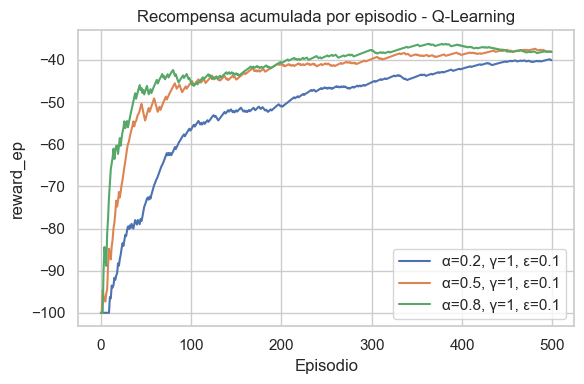

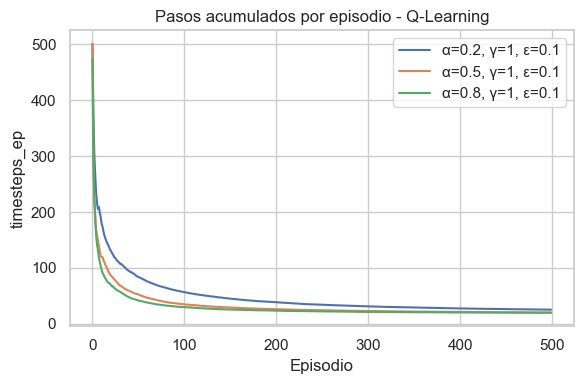

In [689]:
hyperparameter_combinations = [
    {'alpha': 0.2, 'gamma': 1, 'epsilon': 0.1, 'action_space': env.action_space.n},
    {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1, 'action_space': env.action_space.n},
    {'alpha': 0.8, 'gamma': 1, 'epsilon': 0.1, 'action_space': env.action_space.n},
]

# Inicializar el entorno y las variables
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
q = {}
random_state = np.random.RandomState(42)
learning_function = learn_Q_learning  # Asumiendo que ya tienes esta función definida
episodes_to_run = 500  # Número de episodios a ejecutar

# Ejecutar los experimentos
results = run_multiple_hyperparameters(learning_function, episodes_to_run, env, actions, q, random_state, hyperparameter_combinations)

plot_reward_per_episode_multiples_hiperparametros(results, "Q-Learning",'Recompensa acumulada por episodio',objetivo_key="reward_ep")
plot_reward_per_episode_multiples_hiperparametros(results, "Q-Learning",'Pasos acumulados por episodio',objetivo_key="timesteps_ep")

##### 4.3.2) Gamma

Para cambios pequeños no genera grandes movimientos en las recompensas acumuladas. Al priorizar el presente y no tanto las acciones y recompensas futuras, genera menos recompensas acumuladas al aplicar estrategias que quizás no sean las más optimas en el largo plazo.

Ejecutando con hiperparámetros: {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1, 'action_space': 4}
Ejecutando con hiperparámetros: {'alpha': 0.5, 'gamma': 0.95, 'epsilon': 0.1, 'action_space': 4}
Ejecutando con hiperparámetros: {'alpha': 0.5, 'gamma': 0.1, 'epsilon': 0.1, 'action_space': 4}


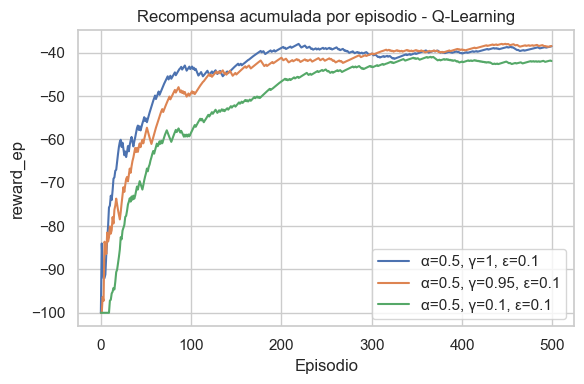

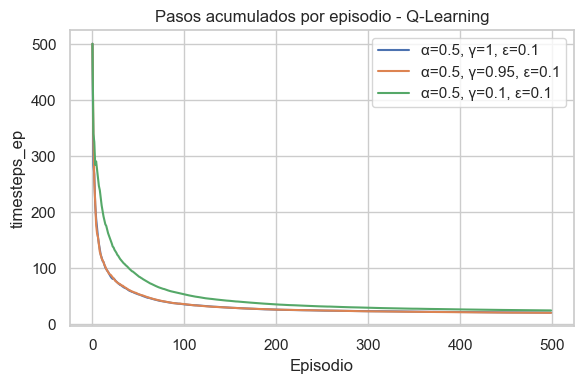

In [690]:
hyperparameter_combinations = [
    {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1, 'action_space': env.action_space.n},
    {'alpha': 0.5, 'gamma': 0.95, 'epsilon': 0.1, 'action_space': env.action_space.n},
    {'alpha': 0.5, 'gamma': 0.1, 'epsilon': 0.1, 'action_space': env.action_space.n},
]

# Inicializar el entorno y las variables
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
q = {}
random_state = np.random.RandomState(42)
learning_function = learn_Q_learning  # Asumiendo que ya tienes esta función definida
episodes_to_run = 500  # Número de episodios a ejecutar

# Ejecutar los experimentos
results = run_multiple_hyperparameters(learning_function, episodes_to_run, env, actions, q, random_state, hyperparameter_combinations)

plot_reward_per_episode_multiples_hiperparametros(results, "Q-Learning",'Recompensa acumulada por episodio',objetivo_key="reward_ep")
plot_reward_per_episode_multiples_hiperparametros(results, "Q-Learning",'Pasos acumulados por episodio',objetivo_key="timesteps_ep")

##### 4.3.3) Epsilon

Podemos ver que valores más pequeños para Epsilon en el caso de Q-Learning tambien conducen a un mayor valor de recompensas acumuladas. En algunos casos, para este algoritmo, se aplican valores de Epsilon decrecientes que generan muy buenas mejoras.

Ejecutando con hiperparámetros: {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.025, 'action_space': 4}
Ejecutando con hiperparámetros: {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.05, 'action_space': 4}
Ejecutando con hiperparámetros: {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1, 'action_space': 4}


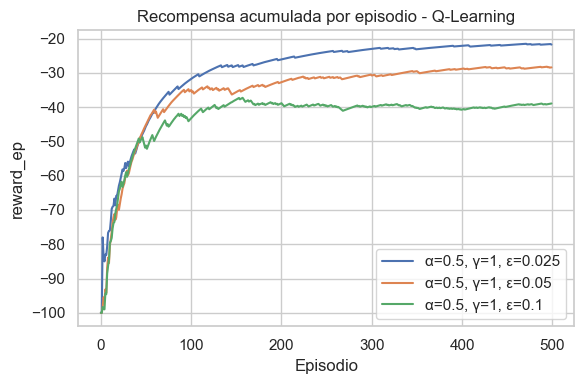

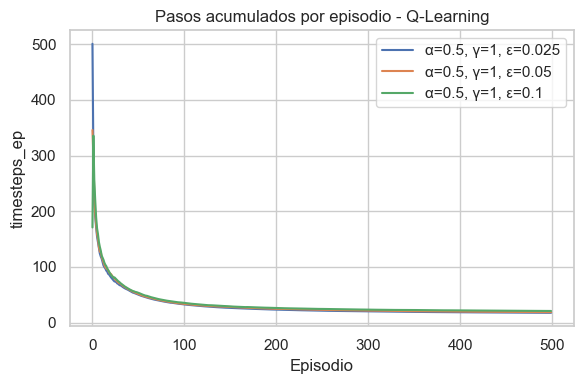

In [691]:
hyperparameter_combinations = [
    {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.025, 'action_space': env.action_space.n},
    {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.05, 'action_space': env.action_space.n},
    {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1, 'action_space': env.action_space.n},
]

# Inicializar el entorno y las variables
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
q = {}
random_state = np.random.RandomState(42)
learning_function = learn_Q_learning  # Asumiendo que ya tienes esta función definida
episodes_to_run = 500  # Número de episodios a ejecutar

# Ejecutar los experimentos
results = run_multiple_hyperparameters(learning_function, episodes_to_run, env, actions, q, random_state, hyperparameter_combinations)

plot_reward_per_episode_multiples_hiperparametros(results, "Q-Learning",'Recompensa acumulada por episodio',objetivo_key="reward_ep")
plot_reward_per_episode_multiples_hiperparametros(results, "Q-Learning",'Pasos acumulados por episodio',objetivo_key="timesteps_ep")